**Vanilla Policy Gradient (VPG) Agent**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    """ A Parameterized Policy Network π_θ """
    
    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_dim)
        self.fc2 = nn.Linear(n_hidden_dim, n_action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

**Note: Policy Gradient Theorem**

Policy gradient methods optimize a policy directly by maximizing the objective function (expected return)
$$
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} [R(\tau)]
$$


The gradient of the objective function is given by
$$
\nabla_\theta J(\theta) = \nabla_\theta \mathbb{E}_{\tau \sim \pi_\theta} [ (R(\tau))] = \mathbb{E}_{\tau \sim \pi_\theta} [\nabla_\theta (R(\tau))] 
$$

Using the log-likelihood trick, we can rewrite this as
$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot R_t\right]
$$

From this, we see that the contribution from a single step is
$$
\nabla_\theta \log \pi_\theta(a_t|s_t) \cdot R_t
$$

Overall, the policy update is performed using gradient ascent:
$$
\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)
$$


In [2]:
from torch.distributions import Categorical
import numpy as np

from typing import *

class Agent:
    """ A Vanilla Policy Gradient (VPG) Agent """

    def __init__(self, obs_space: int, act_space: int):

        # set hyperparameters
        self.alpha = 1e-3 # learning rate
        self.gamma = 0.99 # discount factor
        
        # for gradient clipping
        self.gradient_clipping = 0.5 

        # for entropy regularization
        self.entropy_regularization = 0.05

        # initialize policy
        self.policy = PolicyNetwork(obs_space, act_space)
        self.optimizer = torch.optim.AdamW(self.policy.parameters(), lr=self.alpha)

        self.eps = np.finfo(np.float32).eps.item() # utility: machine epsilon

    def act(self, state: np.ndarray) -> Tuple[int, torch.Tensor]:
        state = torch.from_numpy(state).float().unsqueeze(0)

        # apply policy to select action
        m = Categorical(self.policy(state)) # apply policy
        action = m.sample() # select action
        
        return action.item(), m.log_prob(action), m.entropy()


    def learn(self, rewards: List[float], log_probs: List[torch.Tensor], entropies: List[torch.Tensor]) -> float:
        """
        Update the policy using the policy gradient method.

        Args:
            rewards (List[float]): List of rewards from the environment.
            log_probs (List[torch.Tensor]): List of log probabilities of actions taken.
            entropies (List[torch.Tensor]): List of entropies.

        Returns:
            float: The computed loss for the policy update.
        """
        
        # compute returns
        R = 0
        returns = []
        for r in rewards[::-1]: # iterate backwards (to discount appropriately)
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + self.eps) # normalization

        # compute loss
        loss = []
        for log_prob, R, entropy in zip(log_probs, returns, entropies):
            # maximize log_prob * R (expected return) (+ apply entropy regularization)
            loss.append((-log_prob * R) - (self.entropy_regularization * entropy)) # utility: - to convert gradient ascent to gradient
        loss = torch.cat(loss).sum()

        # perform gradient descent (usual training process)
        self.optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_norm_(self.policy.parameters(), self.gradient_clipping) # apply gradient clipping
        
        self.optimizer.step()

        return loss.item()

In [3]:
import gym

# initialize environment
env = gym.make("CartPole-v1")

obs_space = env.observation_space.shape[0]
act_space = env.action_space.n

print(f"=== CartPole-v1 Environment ===")
print(f" Observation Space:", obs_space)
print(f" Action Space:", act_space)

=== CartPole-v1 Environment ===
 Observation Space: 4
 Action Space: 2


**Note: Monte Carlo Methods**

In reinforcement learning, Monte Carlo methods are used to estimate the value function and to improve the policy by sampling and averaging returns from completed episodes.


In [8]:
# initialize agent
agent = Agent(obs_space, act_space)

n_average = 50

loss_hist = []
reward_hist = []

n_trajectories = 800
for i in range(n_trajectories + 1):

    state = env.reset() # starting new trajectory
    total_reward = 0

    rewards = [] # record sequence of rewards for policy update
    log_probs = [] # record sequence of log_probs for policy update

    entropies = [] # record sequence of entropies for entropy regularization

    T = 1000
    for t in range(1, T):

        # select action
        action, log_prob, entropy = agent.act(state)

        # get feedback from environment
        state, reward, done, _ = env.step(action)
        total_reward += reward
        rewards.append(reward)
        log_probs.append(log_prob)
        entropies.append(entropy)

        # terminate if needed
        if done:
            break

    # update policy with latest trajectory
    loss = agent.learn(rewards, log_probs, entropies) 

    reward_hist.append(total_reward)
    loss_hist.append(loss)

    if i % 50 == 0:
        avg_loss = np.mean(loss_hist[max(0, i-n_average):(i+1)])
        avg_reward = np.mean(reward_hist[max(0, i-n_average):(i+1)])
        print(f"Episode: {i:4} | Average Reward: {avg_reward:3.4f} | Average Loss: {avg_loss:3.4f}")

Episode:    0 | Average Reward: 33.0000 | Average Loss: -1.4717
Episode:   50 | Average Reward: 21.5294 | Average Loss: -0.8317
Episode:  100 | Average Reward: 19.4902 | Average Loss: -0.7860
Episode:  150 | Average Reward: 25.8824 | Average Loss: -0.9276
Episode:  200 | Average Reward: 42.4314 | Average Loss: -1.7068
Episode:  250 | Average Reward: 57.2157 | Average Loss: -2.4367
Episode:  300 | Average Reward: 65.8627 | Average Loss: -3.1112
Episode:  350 | Average Reward: 112.6275 | Average Loss: -5.0798
Episode:  400 | Average Reward: 132.1961 | Average Loss: -6.7559
Episode:  450 | Average Reward: 167.2941 | Average Loss: -8.0469
Episode:  500 | Average Reward: 205.3333 | Average Loss: -8.1560
Episode:  550 | Average Reward: 147.2157 | Average Loss: -7.3454
Episode:  600 | Average Reward: 186.0784 | Average Loss: -8.5501
Episode:  650 | Average Reward: 275.5882 | Average Loss: -12.9659
Episode:  700 | Average Reward: 326.4706 | Average Loss: -13.6715
Episode:  750 | Average Reward

In [5]:
# close
env.close()

In [6]:
# save
# torch.save(agent.policy.state_dict(), 'VPG.pth')

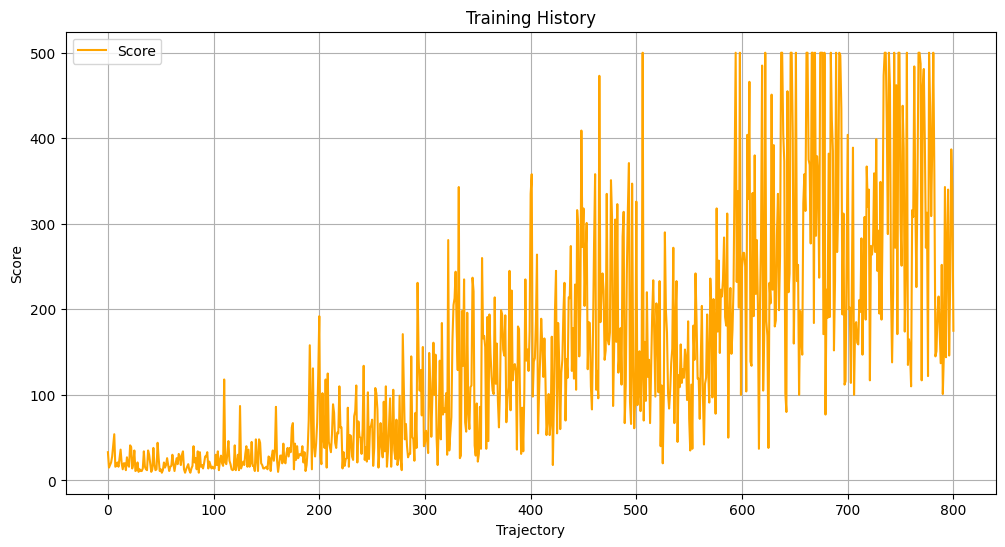

In [12]:
import matplotlib.pyplot as plt

# plot results
plt.figure(figsize=(12, 6))
plt.plot(reward_hist, label='Score', color="#FFA500")
plt.title('Training History')
plt.xlabel('Trajectory')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()